### MACHINE LEARNING FOR FINANCIAL MARKETS

TOPIC: IMPROVING TIME SERIES FORECASTING WITH SYNTHETIC DATA

Tools used: LSTM Neural Networks (multivariate) and TimeGAN (specifically introduced for Time Series)

**GOAL**: predict the stock price at t using all the information of day t-1 (Volume, Open, Close, High, Low)

## Proposed Methodology
The methodology is divided into two main parts:

**Part 1: Training a multivariate LSTM  on Real Data**
- Training Phase: Train a multivariate LSTM Neural Networks using only the original (real) training dataset.
- Prediction and Evaluation: Apply the trained multivariate LSTM model to unseen test data to make predictions. Evaluate the model's performance using metrics such as Mean Squared Error (MSE) and Mean Absolute Error (MAE).

**Part 2: Augmenting the Dataset with Synthetic Data and Training a New multivariate LSTM Model**
- Synthetic Data Generation: Build and train a TimeGAN (Time-series Generative Adversarial Network) to generate synthetic time-series data. Combine the synthetic data with the original training dataset to create an augmented training dataset.
- Training Phase: Train a multivariate LSTM on the augmented training dataset.
- Prediction and Evaluation: Apply the new multivariate LSTM model to the same unseen test data to make predictions. Evaluate its performance using the same metrics (MSE and MAE).

**Part 3: Comparison and Analysis**
- Compare the performance of the two multivariate LSTM models: The first model, trained only on real data. The second model, trained on the augmented dataset (real + synthetic data) Measure whether the inclusion of synthetic data leads to an improvement in performance.


**Expected Outcomes**
The comparison will reveal whether the augmented dataset (real + synthetic data) leads to better performance compared to using only real data.
If the synthetic data is of high quality and captures the underlying patterns of the real data, the second multivariate LSTM model is expected to achieve lower MSE and MAE on the test set.

In [22]:
#Import all the necessary libraries for LSTM and GANs

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam #adam is the optimizer we are going to use
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout, BatchNormalization

In [2]:
#load the dataset (data from 02/20/2015 to 02/19/2025)
path = '/Users/francescavasta/Desktop/ADSEM/II YEAR I SEM/ML for financial markets/MSFT historical data.csv'
df = pd.read_csv(path)
df

,Date,Close/Last,Volume,Open,High,Low
0,02/19/2025,$414.77,24114200,$407.88,$415.49,$407.65
1,02/18/2025,$409.64,21423050,$408.00,$410.597,$406.50
2,02/14/2025,$408.43,22758460,$407.79,$408.91,$405.88
3,02/13/2025,$410.54,23891730,$407.00,$411.00,$406.36
4,02/12/2025,$409.04,19121730,$407.21,$410.75,$404.3673
...,...,...,...,...,...,...
2510,02/26/2015,$44.055,26524300,$43.99,$44.23,$43.89
2511,02/25/2015,$43.99,29749090,$43.95,$44.09,$43.80
2512,02/24/2015,$44.09,25262080,$44.15,$44.30,$43.92
2513,02/23/2015,$44.15,32510550,$43.70,$44.19,$43.65


In [3]:
df.info()

#we see that we have a problem with the date format because it is a string
#also the stock value is a string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
 2   Volume      2515 non-null   int64 
 3   Open        2515 non-null   object
 4   High        2515 non-null   object
 5   Low         2515 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.0+ KB


In [4]:
#handling of ['Date'] values
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month, day, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month = month, day=day)

#testing the function
#datetime_object = str_to_datetime('02/20/2015')
#datetime_object

df['Date'] = df['Date'].apply(str_to_datetime)
df

,Date,Close/Last,Volume,Open,High,Low
0,2025-02-19,$414.77,24114200,$407.88,$415.49,$407.65
1,2025-02-18,$409.64,21423050,$408.00,$410.597,$406.50
2,2025-02-14,$408.43,22758460,$407.79,$408.91,$405.88
3,2025-02-13,$410.54,23891730,$407.00,$411.00,$406.36
4,2025-02-12,$409.04,19121730,$407.21,$410.75,$404.3673
...,...,...,...,...,...,...
2510,2015-02-26,$44.055,26524300,$43.99,$44.23,$43.89
2511,2015-02-25,$43.99,29749090,$43.95,$44.09,$43.80
2512,2015-02-24,$44.09,25262080,$44.15,$44.30,$43.92
2513,2015-02-23,$44.15,32510550,$43.70,$44.19,$43.65


In [5]:
#handling of Close/Last values
df["Close/Last"] = df["Close/Last"].str.replace(r"\$", "", regex=True) # to remove $
df["Close/Last"] = pd.to_numeric(df["Close/Last"], errors="coerce")
df["Close/Last"].astype(float)

df["Open"] = df["Open"].str.replace(r"\$", "", regex=True) # to remove $
df["Open"] = pd.to_numeric(df["Open"], errors="coerce")
df['Open'].astype(float)

df["High"] = df["High"].str.replace(r"\$", "", regex=True) # to remove $
df["High"] = pd.to_numeric(df["High"], errors="coerce")
df['High'].astype(float)

df["Low"] = df["Low"].str.replace(r"\$", "", regex=True) # to remove $
df["Low"] = pd.to_numeric(df["Low"], errors="coerce")
df['Low'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2515 non-null   datetime64[ns]
 1   Close/Last  2515 non-null   float64       
 2   Volume      2515 non-null   int64         
 3   Open        2515 non-null   float64       
 4   High        2515 non-null   float64       
 5   Low         2515 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.0 KB


In [6]:
#we prefer to have our data ordered chronologically from past to future 
df = df.sort_values(by="Date", ascending=True)
df = df.reset_index(drop=True)
df

,Date,Close/Last,Volume,Open,High,Low
0,2015-02-20,43.855,29710140,43.51,43.880,43.2900
1,2015-02-23,44.150,32510550,43.70,44.190,43.6500
2,2015-02-24,44.090,25262080,44.15,44.300,43.9200
3,2015-02-25,43.990,29749090,43.95,44.090,43.8000
4,2015-02-26,44.055,26524300,43.99,44.230,43.8900
...,...,...,...,...,...,...
2510,2025-02-12,409.040,19121730,407.21,410.750,404.3673
2511,2025-02-13,410.540,23891730,407.00,411.000,406.3600
2512,2025-02-14,408.430,22758460,407.79,408.910,405.8800
2513,2025-02-18,409.640,21423050,408.00,410.597,406.5000


In [7]:
#now we want to remove the index and make the date itslef as the index
df.index = df.pop('Date')
df

,Close/Last,Volume,Open,High,Low
Date,,,,,
2015-02-20,43.855,29710140,43.51,43.880,43.2900
2015-02-23,44.150,32510550,43.70,44.190,43.6500
2015-02-24,44.090,25262080,44.15,44.300,43.9200
2015-02-25,43.990,29749090,43.95,44.090,43.8000
2015-02-26,44.055,26524300,43.99,44.230,43.8900
...,...,...,...,...,...
2025-02-12,409.040,19121730,407.21,410.750,404.3673
2025-02-13,410.540,23891730,407.00,411.000,406.3600
2025-02-14,408.430,22758460,407.79,408.910,405.8800


In [8]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)
    
    target_date = first_date
    dates = []
    X, Y = [], []
    
    last_time = False
    while True:
        # Seleziona il giorno precedente (t-1)
        df_subset = dataframe.loc[:target_date].tail(2)  # Ultimi due giorni, prendo solo il primo
        
        if len(df_subset) != 2:
            print(f'Error: Not enough data for date {target_date}')
            return
        
        prev_day = df_subset.iloc[0]  # Prendo solo il giorno t-1
        target_value = df_subset.iloc[1]['Close/Last']  # Prendo Close del giorno t
        
        x = prev_day[['Open', 'High', 'Low', 'Close/Last', 'Volume']].to_numpy()
        
        dates.append(target_date)
        X.append(x)
        Y.append(target_value)
        
        # Trova la prossima data valida
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)
        
        if last_time:
            break
        
        target_date = next_date
        
        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({'Target Date': dates})
    
    X = np.array(X)
    feature_names = ['Open-1', 'High-1', 'Low-1', 'Close-1', 'Volume-1']
    for i, feature in enumerate(feature_names):
        ret_df[feature] = X[:, i]
    
    ret_df['Target'] = Y
    
    return ret_df


In [9]:
#apply the function. The start date can't be 20/02/2015 because it must have 5 other dates prior
windowed_df = df_to_windowed_df(df,'02/23/2015', '02/19/2025')

windowed_df

,Target Date,Open-1,High-1,Low-1,Close-1,Volume-1,Target
0,2015-02-23,43.51,43.880,43.2900,43.855,29710140.0,44.150
1,2015-02-24,43.70,44.190,43.6500,44.150,32510550.0,44.090
2,2015-02-25,44.15,44.300,43.9200,44.090,25262080.0,43.990
3,2015-02-26,43.95,44.090,43.8000,43.990,29749090.0,44.055
4,2015-02-27,43.99,44.230,43.8900,44.055,26524300.0,43.850
...,...,...,...,...,...,...,...
2509,2025-02-12,409.64,412.490,409.3000,411.440,18140590.0,409.040
2510,2025-02-13,407.21,410.750,404.3673,409.040,19121730.0,410.540
2511,2025-02-14,407.00,411.000,406.3600,410.540,23891730.0,408.430
2512,2025-02-18,407.79,408.910,405.8800,408.430,22758460.0,409.640


In [10]:
#this function helps us to distinguish the target variable from the predictors
def windowed_df_to_date_X_y (windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix  = df_as_np [:, 1:-1] #to take only the "Target-n" columns
    #middle matrix is not the final input matrix

    X = middle_matrix.reshape((len(dates), 1, middle_matrix.shape[1]))  # (samples, timesteps=1, features=5) 
    Y = df_as_np[:, -1] #target variable

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X_orig, y_orig = windowed_df_to_date_X_y(windowed_df)

dates.shape, X_orig.shape, y_orig.shape

((2514,), (2514, 1, 5), (2514,))

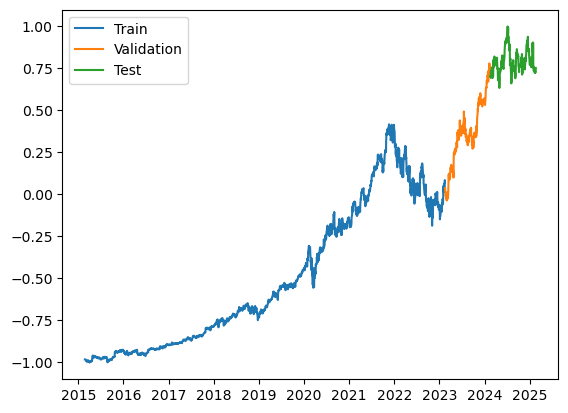

In [11]:
#LSTM performs better when using Standardized data 
#we need to use this range because the TimeGAN will use "tanh", which requires data scaled between -1 and 1.
X_scaler = MinMaxScaler(feature_range=(-1, 1)) 
y_scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the data of "windowed_df"
windowed_df.iloc[:, 1:-1] = X_scaler.fit_transform(windowed_df.iloc[:, 1:-1])  # To standardize X
windowed_df.iloc[:, -1] = y_scaler.fit_transform(windowed_df.iloc[:, -1].values.reshape(-1, 1))  # To standardize y

# We need to apply again the function to obtain dates, X, y
dates, X_norm, y_norm = windowed_df_to_date_X_y(windowed_df)

# Now we split the data and we also visualize the different sets on the graph
#with time series we can't do random splittings because the cronological order is important, so we use the quantiles

q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)

#splitting the standardized dataset
dates_train, X_train_norm, y_train_norm = dates[:q_80], X_norm[:q_80], y_norm[:q_80]
dates_val, X_val_norm, y_val_norm = dates[q_80:q_90], X_norm[q_80:q_90], y_norm[q_80:q_90]
dates_test, X_test_norm, y_test_norm = dates[q_90:], X_norm[q_90:], y_norm[q_90:] #from q_90 onwards

#splitting also the non-standardized dataset for future plots
dates_train, X_train_orig, y_train_orig = dates[:q_80], X_orig[:q_80], y_orig[:q_80]
dates_val, X_val_orig, y_val_orig = dates[q_80:q_90], X_orig[q_80:q_90], y_orig[q_80:q_90]
dates_test, X_test_orig, y_test_orig = dates[q_90:], X_orig[q_90:], y_orig[q_90:] #from q_90 onwards

plt.plot(dates_train, y_train_norm)
plt.plot(dates_val, y_val_norm)
plt.plot(dates_test, y_test_norm)

plt.legend(['Train', 'Validation', 'Test'])

## PART 3: TRAINING OF THE LSTM MODEL (MULTIVARIATE)

In [12]:
model = Sequential([layers.Input((1, 5)), #1 timestep and 5 predictors
                    layers.LSTM(64), #the higher is this number, the higher is the risk of overfitting
                    layers.Dense(32, activation ='tanh'),
                    layers.Dense(32, activation ='tanh'),
                    layers.Dense(1) #by default the output is linear
                    ])

model.compile(loss= tf.keras.losses.Huber(delta=0.1), 
              optimizer=Adam(learning_rate=0.0001),
              metrics = ['mean_absolute_error'])

model.fit(X_train_norm,y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs = 100)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0507 - mean_absolute_error: 0.5550 - val_loss: 0.0393 - val_mean_absolute_error: 0.4430
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0289 - mean_absolute_error: 0.3368 - val_loss: 0.0422 - val_mean_absolute_error: 0.4718
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0107 - mean_absolute_error: 0.1497 - val_loss: 0.0248 - val_mean_absolute_error: 0.2978
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040 - mean_absolute_error: 0.0752 - val_loss: 0.0031 - val_mean_absolute_error: 0.0714
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3843e-04 - mean_absolute_error: 0.0156 - val_loss: 7.1496e-04 - val_mean_absolute_error: 0.0298
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5380e-04 - mean_absolute_error: 0.0119 - val_loss: 7.1979e-04 - val_mean_absolute_error: 0.0300
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3999e-04 - mean_absolute_erro

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train Set Performance Metrics:
MAE: $2.06
RMSE: $3.28


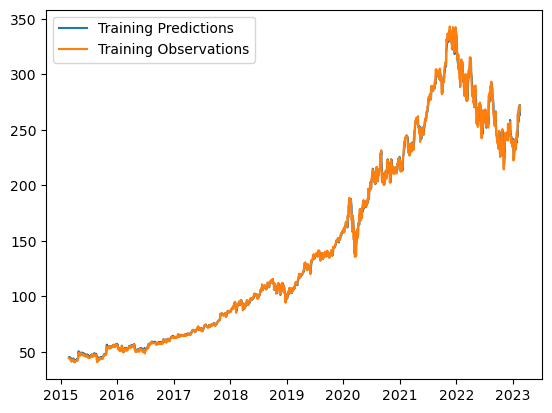

In [13]:
#the model was trained with X_train_norm and y_train_norm, now we use X_train_norm to make training predictions
#then we compare y_train (true) with train predictions
train_predictions_norm = model.predict(X_train_norm).flatten ()
#back to original scale with "inverse_transform" and reshape
train_predictions_orig = y_scaler.inverse_transform(train_predictions_norm.reshape(-1, 1)).flatten()


plt.plot (dates_train, train_predictions_orig) 
plt.plot (dates_train, y_train_orig)
plt. legend (['Training Predictions', 'Training Observations'])

#Performance on training set
mae_train = mean_absolute_error(y_train_orig, train_predictions_orig)
rmse_train = np.sqrt(mean_squared_error(y_train_orig, train_predictions_orig))
               
print("\nTrain Set Performance Metrics:")
print(f"MAE: ${mae_train:.2f}")
print(f"RMSE: ${rmse_train:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Validation Set Performance Metrics:
MAE: $5.58
RMSE: $6.95


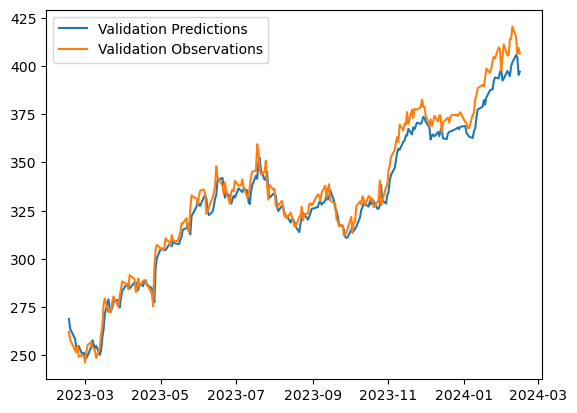

In [14]:
#Now we use X_val to try to predict y_val
val_predictions_norm = model.predict (X_val_norm).flatten () 
val_predictions_orig = y_scaler.inverse_transform(val_predictions_norm.reshape(-1, 1)).flatten()

plt.plot (dates_val, val_predictions_orig) 
plt.plot (dates_val, y_val_orig)
plt. legend(['Validation Predictions', 'Validation Observations'])

#Performance on validation set
mae_val = mean_absolute_error(y_val_orig, val_predictions_orig)
rmse_val = np.sqrt(mean_squared_error(y_val_orig, val_predictions_orig))

print("\nValidation Set Performance Metrics:")
print(f"MAE: ${mae_val:.2f}")
print(f"RMSE: ${rmse_val:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<>:17: SyntaxWarning: invalid escape sequence '\T'
<>:17: SyntaxWarning: invalid escape sequence '\T'
/var/folders/ls/mj9skg6x7j38ls1ncwhc9s400000gn/T/ipykernel_79376/3743027223.py:17: SyntaxWarning: invalid escape sequence '\T'
  print("\Test Set Performance Metrics:")


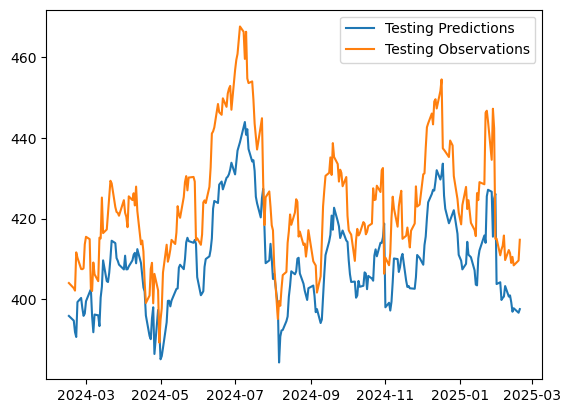

\Test Set Performance Metrics:
MAE: $14.13
RMSE: $15.20


In [15]:
#Finally we use the LSTM model to predict y_test, using X_test. 
#In other words, the model is now fit using data that the model has never seen before.

test_predictions_norm = model.predict(X_test_norm).flatten()
test_predictions_orig = y_scaler.inverse_transform(test_predictions_norm.reshape(-1, 1)).flatten()


plt.plot(dates_test, test_predictions_orig, label='Testing Predictions')
plt.plot(dates_test, y_test_orig, label='Testing Observations')
plt.legend()
plt.show()

#Performance on test set
mae_test = mean_absolute_error(y_test_orig, test_predictions_orig)
rmse_test = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig))

print("\Test Set Performance Metrics:")
print(f"MAE: ${mae_test:.2f}")
print(f"RMSE: ${rmse_test:.2f}")

In [23]:
class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=64, batch_size=128):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.build_model()

        self.d_losses = []
        self.g_losses = []

    def build_model(self):
        # Encoder 
        self.encoder = Sequential([
            LSTM(self.hidden_dim * 2, return_sequences=True, input_shape=(self.seq_len, self.feature_dim)),
            BatchNormalization(),
            LSTM(self.hidden_dim, return_sequences=False),
            BatchNormalization()
        ])

        # Decoder 
        self.decoder = Sequential([
            Dense(self.hidden_dim * 2, activation='relu'),
            BatchNormalization(),
            Dense(self.seq_len * self.feature_dim, activation='tanh'),
            BatchNormalization(),
            tf.keras.layers.Reshape((self.seq_len, self.feature_dim))
        ])

        # Generator 
        self.generator = Sequential([
            LSTM(self.hidden_dim * 4, return_sequences=True, input_shape=(self.seq_len, self.feature_dim)),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(self.hidden_dim * 2, return_sequences=True),
            BatchNormalization(),
            Dropout(0.3),
            TimeDistributed(Dense(self.hidden_dim, activation='relu')),
            BatchNormalization(),
            TimeDistributed(Dense(self.feature_dim, activation='tanh'))
        ])

        # Supervisor network 
        self.supervisor = Sequential([
            LSTM(self.hidden_dim * 2, return_sequences=True, input_shape=(self.seq_len, self.hidden_dim)),
            BatchNormalization(),
            LSTM(self.hidden_dim, return_sequences=True),
            BatchNormalization()
        ])

        # Discriminator 
        self.discriminator = Sequential([
            LSTM(self.hidden_dim * 4, return_sequences=True, input_shape=(self.seq_len, self.feature_dim)),
            BatchNormalization(),
            LSTM(self.hidden_dim * 2, return_sequences=False),
            BatchNormalization(),
            Dropout(0.4),
            Dense(self.hidden_dim, activation='relu'),
            BatchNormalization(),
            Dense(1, activation='sigmoid')
        ])

        # compile model
        self.encoder.compile(optimizer='adam', loss='mse')
        self.decoder.compile(optimizer='adam', loss='mse')
        self.generator.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='mse'
        )
        self.supervisor.compile(optimizer='adam', loss='mse')
        self.discriminator.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5),
            loss='binary_crossentropy'
        )

        # GAN Model with noise injection
        self.discriminator.trainable = False
        gan_input = tf.keras.Input(shape=(self.seq_len, self.feature_dim))
        noise = tf.random.normal(shape=(self.batch_size, self.seq_len, self.feature_dim), mean=0.0, stddev=0.1)
        generated_samples = self.generator(gan_input + noise)
        gan_output = self.discriminator(generated_samples)
        self.gan = Model(gan_input, gan_output)
        self.gan.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
            loss='binary_crossentropy'
        )

    def plot_losses(self):
        """
        Visualizza i grafici delle loss con più dettagli
        """
        plt.figure(figsize=(15, 6))
        
        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(self.d_losses, label='Discriminator Loss', alpha=0.7, color='blue')
        plt.plot(self.g_losses, label='Generator Loss', alpha=0.7, color='red')
        plt.title('Training Losses over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.show()
        
        # Print statistics
        print("\nLoss Statistics:")
        print(f"Discriminator - Mean: {np.mean(self.d_losses):.4f}, Std: {np.std(self.d_losses):.4f}")
        print(f"Generator - Mean: {np.mean(self.g_losses):.4f}, Std: {np.std(self.g_losses):.4f}")

    def train(self, data, epochs=1000):
        self.d_losses = []
        self.g_losses = []
        
        for epoch in range(epochs):
            idx = np.random.randint(0, data.shape[0], self.batch_size)
            real_samples = data[idx]
            
            noise_factor = 0.05
            real_samples_noisy = real_samples + noise_factor * np.random.normal(0, 1, real_samples.shape)
        
            noise = np.random.normal(0, 1, (self.batch_size, self.seq_len, self.feature_dim))
            fake_samples = self.generator.predict(noise)

            # Train Discriminator
            real_labels = np.random.uniform(0.9, 1.0, (self.batch_size, 1))  # Label smoothing
            fake_labels = np.random.uniform(0.0, 0.1, (self.batch_size, 1))
            
            d_loss_real = self.discriminator.train_on_batch(real_samples_noisy, real_labels)
            d_loss_fake = self.discriminator.train_on_batch(fake_samples, fake_labels)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            # Train Generator
            noise = np.random.normal(0, 1, (self.batch_size, self.seq_len, self.feature_dim))
            g_loss = self.gan.train_on_batch(noise, np.ones((self.batch_size, 1)))

            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}:")
                print(f"D Loss: {d_loss:.4f} (Real: {d_loss_real:.4f}, Fake: {d_loss_fake:.4f})")
                print(f"G Loss: {g_loss:.4f}")
                print("-" * 50)
        
        # show graphs at the end
        self.plot_losses()


    def generate_synthetic_data(self, num_samples, X_scaler, seq_len):
        # Add noise
        base_noise = np.random.normal(0, 1, (num_samples, seq_len, self.feature_dim))
        additional_noise = np.random.normal(0, 0.1, (num_samples, seq_len, self.feature_dim))
        noise = base_noise + additional_noise
        
        generated_data = self.generator.predict(noise)
        
        perturbations = np.random.normal(0, 0.05, generated_data.shape)
        generated_data += perturbations
        
        # Inverse scaler
        generated_data_2d = generated_data.reshape(-1, self.feature_dim)
        generated_denorm = X_scaler.inverse_transform(generated_data_2d)
        generated_final = generated_denorm.reshape(num_samples, seq_len, self.feature_dim)
        
        return generated_final

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0/1000:
D Loss: 0.6933 (Real: 0.6933, Fake: 0.6932)
G Loss: 0.6932
--------------------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

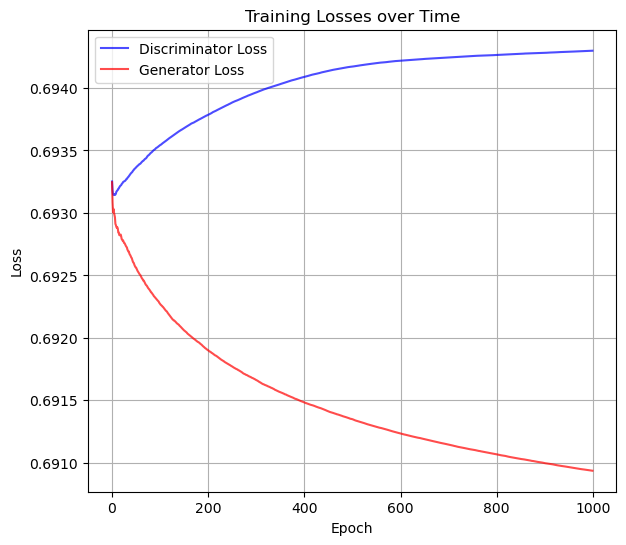


Loss Statistics:
Discriminator - Mean: 0.6940, Std: 0.0003
Generator - Mean: 0.6915, Std: 0.0005


In [24]:
# Initialize and train TimeGAN
seq_len = X_train_norm.shape[1] #output: 1 (which is the timestep)
feature_dim = 5
timegan = TimeGAN(seq_len, feature_dim, hidden_dim=64)
timegan.train(X_train_norm, epochs=1000)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


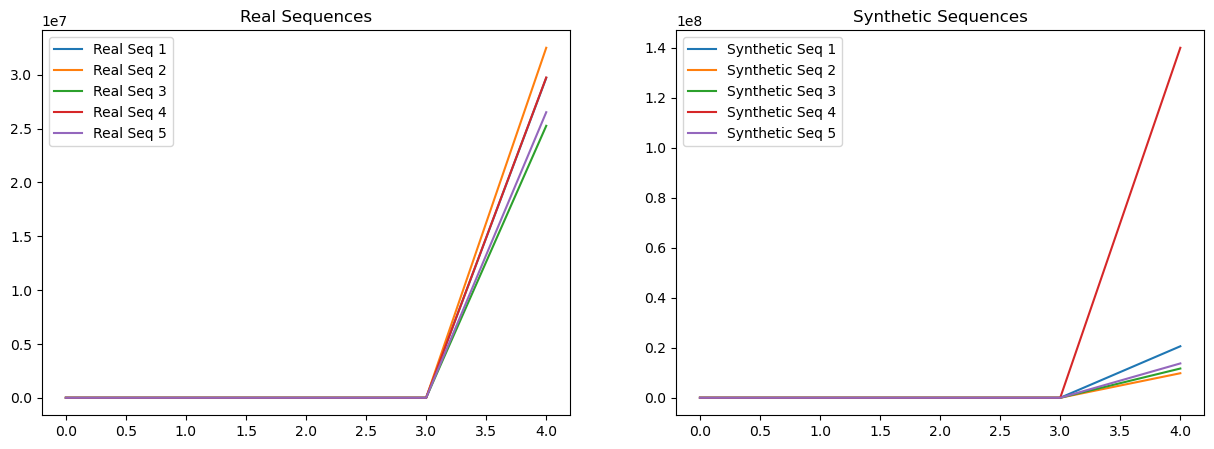

In [25]:
# 1. Generate synthetic data using TimeGAN
num_synthetic = int(X_train_norm.shape[0] * 0.3)  # Genera il 30% di dati sintetici rispetto al dataset originale
synthetic_sequences = timegan.generate_synthetic_data(num_synthetic, X_scaler, seq_len)

# 2. Use the trained LSTM model to generate synthetic targets (predictions for the synthetic sequences)
synthetic_targets = model.predict(synthetic_sequences)
synthetic_targets= y_scaler.inverse_transform(synthetic_targets.reshape(-1, 1)).flatten()

# 3. Visualize the comparison between real and synthetic sequences
plt.figure(figsize=(15, 5))

# Plot real sequences
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(X_train_orig[i, 0,:], label=f'Real Seq {i+1}')
plt.title('Real Sequences')
plt.legend()

# Plot synthetic sequences
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(synthetic_sequences[i, 0, :] , label=f'Synthetic Seq {i+1}')
plt.title('Synthetic Sequences')
plt.legend()

plt.show()

In [26]:
# 3. Combine syntehtic and real
X_train_augmented = np.concatenate([X_train_norm, synthetic_sequences], axis=0)
y_train_augmented = np.concatenate([y_train_norm, synthetic_targets], axis=0)

# 4. Shuffle the data
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

X_train_augmented
y_train_augmented

array([2.136120e-01, 5.855154e+02, 5.855154e+02, ..., 5.855154e+02,
       6.925363e-02, 5.855154e+02], dtype=float32)

In [27]:
# 5. Train LSTM again with the augmented training dataset
model_augmented = Sequential([
    layers.Input((1, 5)),
    layers.LSTM(64),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1)
])

model_augmented.compile(
    loss=tf.keras.losses.Huber(delta=0.1),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mean_absolute_error']
)

# Addestra il modello con i dati aumentati
history_augmented = model_augmented.fit(
    X_train_augmented, 
    y_train_augmented,
    validation_data=(X_val_norm, y_val_norm),
    epochs=100
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13.4545 - mean_absolute_error: 134.5931 - val_loss: 0.0379 - val_mean_absolute_error: 0.4294
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.4672 - mean_absolute_error: 134.7175 - val_loss: 0.0145 - val_mean_absolute_error: 0.1943
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.5764 - mean_absolute_error: 125.7961 - val_loss: 7.3271e-04 - val_mean_absolute_error: 0.0283
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.1676 - mean_absolute_error: 141.7048 - val_loss: 7.6970e-04 - val_mean_absolute_error: 0.0284
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.8474 - mean_absolute_error: 128.5022 - val_loss: 8.8522e-04 - val_mean_absolute_error: 0.0308
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.1253 - mean_absolute_error: 131.2814 - val_loss: 9.2084e-04 - val_mean_absolute_error: 0.0320
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.5166 - mea

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


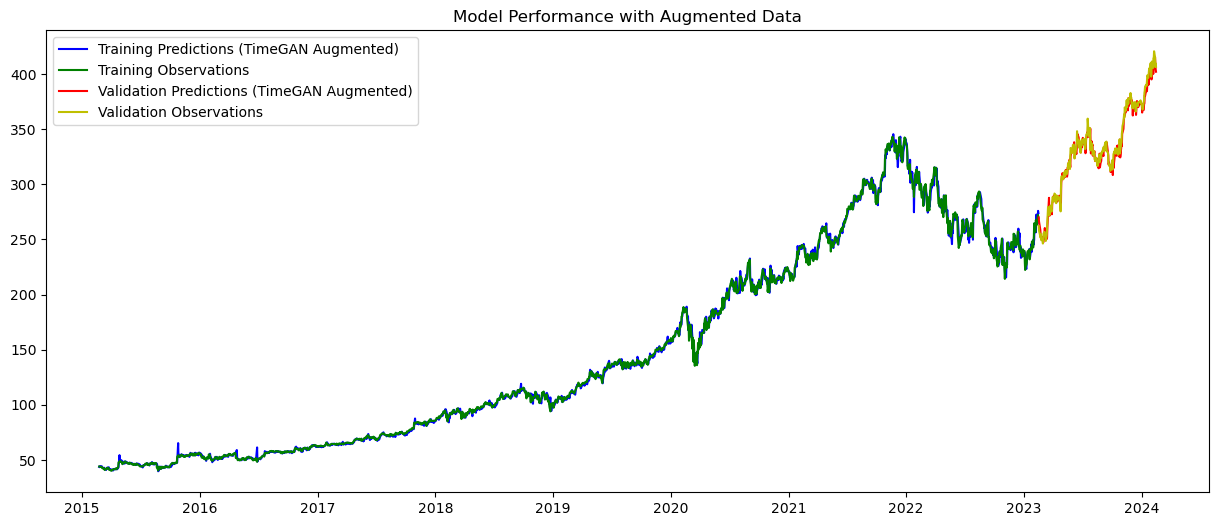

In [28]:
# Check the performance of the LSTM model with AUGMENTED DATA
train_predictions_aug_norm = model_augmented.predict(X_train_norm)
val_predictions_aug_norm = model_augmented.predict(X_val_norm)


train_predictions__aug_orig = y_scaler.inverse_transform(train_predictions_aug_norm.reshape(-1, 1))
val__predictions__aug_orig = y_scaler.inverse_transform(val_predictions_aug_norm.reshape(-1, 1))

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(dates_train, train_predictions__aug_orig, 'b', label='Training Predictions (TimeGAN Augmented)')
plt.plot(dates_train, y_train_orig, 'g', label='Training Observations')
plt.plot(dates_val, val__predictions__aug_orig, 'r', label='Validation Predictions (TimeGAN Augmented)')
plt.plot(dates_val, y_val_orig, 'y', label='Validation Observations')
plt.legend()
plt.title('Model Performance with Augmented Data')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


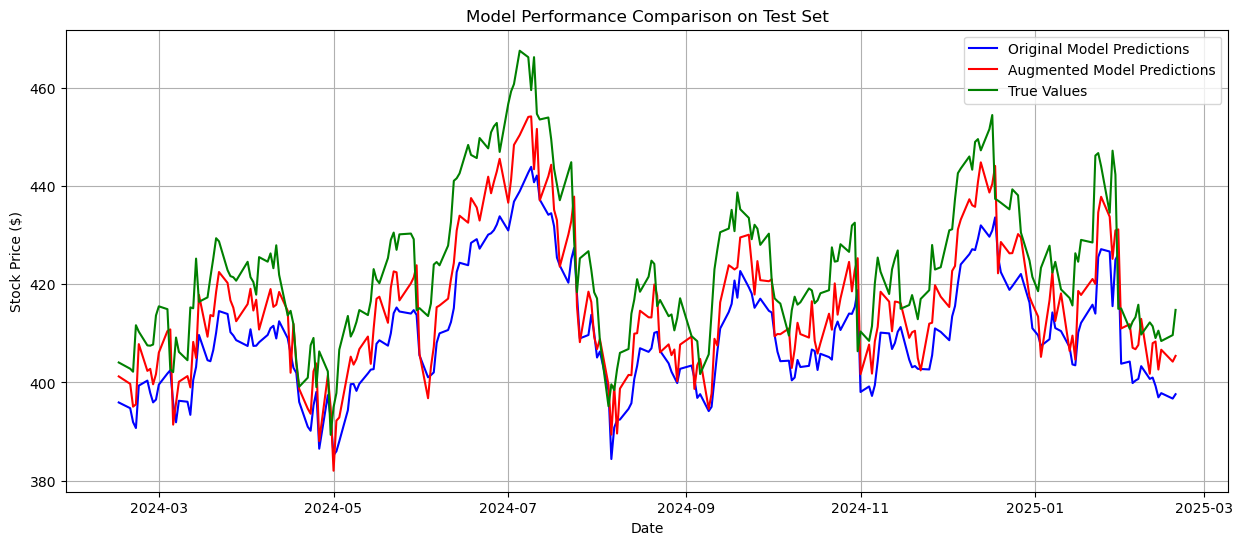

In [29]:
# 1. Make predictions using both models 
test_predictions_norm = model.predict(X_test_norm)  # modello originale
test_predictions_aug_norm = model_augmented.predict(X_test_norm) # modello con dati aumentati

test_predictions_orig = y_scaler.inverse_transform(test_predictions_norm.reshape(-1, 1))
test_predictions__aug_orig = y_scaler.inverse_transform(test_predictions_aug_norm.reshape(-1, 1))

# 2. Comparison
plt.figure(figsize=(15, 6))
plt.plot(dates_test, test_predictions_orig, 'b', label='Original Model Predictions')
plt.plot(dates_test, test_predictions__aug_orig, 'r', label='Augmented Model Predictions')
plt.plot(dates_test, y_test_orig, 'g', label='True Values')
plt.title('Model Performance Comparison on Test Set')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
#Original model performance
mae_original = mean_absolute_error(y_test_orig, test_predictions_orig)
rmse_original = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig))

#Performance of model with augmented data
mae_augmented = mean_absolute_error(y_test_orig, test_predictions__aug_orig)
rmse_augmented = np.sqrt(mean_squared_error(y_test_orig, test_predictions__aug_orig))

print("\nTest Set Performance Metrics:")
print("\nOriginal Model:")
print(f"MAE: ${mae_original:.2f}")
print(f"RMSE: ${rmse_original:.2f}")

print("\nAugmented Model:")
print(f"MAE: ${mae_augmented:.2f}")
print(f"RMSE: ${rmse_augmented:.2f}")

#Improvement thanks to the synthetic data
mae_improvement = ((mae_original - mae_augmented) / mae_original) * 100
rmse_improvement = ((rmse_original - rmse_augmented) / rmse_original) * 100

print(f"\nImprovement with Data Augmentation:")
print(f"MAE Improvement: {mae_improvement:.2f}%")
print(f"RMSE Improvement: {rmse_improvement:.2f}%")


Test Set Performance Metrics:

Original Model:
MAE: $14.13
RMSE: $15.20

Augmented Model:
MAE: $8.72
RMSE: $10.04

Improvement with Data Augmentation:
MAE Improvement: 38.29%
RMSE Improvement: 33.96%
